In [2]:
import numpy as np
from cryptocmd import CmcScraper
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
df_dict = {}
scaled_coins = {}
coins = ['btc', 'eth', 'aave', 'doge', 'xrp']
coin_names = ['Bitcoin', 'Ethereum', 'Aave', 'Dogecoin', 'XRP']
for coin, name in zip(coins, coin_names):
    scraper = CmcScraper(coin_code=coin, coin_name=name)
    df_dict[name] = scraper.get_dataframe()

for df in df_dict.values():
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)


scaler = MinMaxScaler()
for name, df in df_dict.items():
    df = df[['Open', 'Low', 'Close', 'Volume', 'Market Cap', 'High']]
    scaled_coins[name] = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)





In [4]:
results = {}
for coin, df_coin in df_dict.items():
    X = df_coin[['Open', 'Low', 'Close', 'Volume', 'Market Cap']].values
    Y = df_coin[['High']].values.astype('float32')

    Y_log = np.log1p(Y)

    scaler = MinMaxScaler(feature_range=(0, 1))
    Y_scaled = scaler.fit_transform(Y_log)

    k_folds = 5
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    train_scores = []
    test_scores = []
    r2_scores_train = []
    r2_scores_test = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y_scaled[train_index], Y_scaled[test_index]

        model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

        model.fit(X_train, Y_train.ravel())

        train_pred = model.predict(X_train).reshape(-1, 1)
        test_pred = model.predict(X_test).reshape(-1, 1)

        train_pred_unscaled = np.expm1(scaler.inverse_transform(train_pred))
        test_pred_unscaled = np.expm1(scaler.inverse_transform(test_pred))
        train_y_unscaled = np.expm1(scaler.inverse_transform(Y_train.reshape(-1, 1)))
        test_y_unscaled = np.expm1(scaler.inverse_transform(Y_test.reshape(-1, 1)))

        train_score = np.sqrt(mean_squared_error(train_y_unscaled, train_pred_unscaled))
        test_score = np.sqrt(mean_squared_error(test_y_unscaled, test_pred_unscaled))
        train_scores.append(train_score)
        test_scores.append(test_score)

        train_r2 = r2_score(train_y_unscaled, train_pred_unscaled)
        test_r2 = r2_score(test_y_unscaled, test_pred_unscaled)
        r2_scores_train.append(train_r2)
        r2_scores_test.append(test_r2)

    results[coin] = {'avg_rmse_train': np.mean(train_scores), 'avg_rmse_test': np.mean(test_scores), 'avg_r2_train': np.mean(r2_scores_train) ,
                     'avg_r2_test': np.mean(r2_scores_test)}
    print(f"{coin}: Average Train RMSE: {np.mean(train_scores):.2f}")
    print(f"{coin}: Average Test RMSE: {np.mean(test_scores):.2f}")





Bitcoin: Average Train RMSE: 358.06
Bitcoin: Average Test RMSE: 444.60
Ethereum: Average Train RMSE: 27.36
Ethereum: Average Test RMSE: 36.98
Aave: Average Train RMSE: 4.13
Aave: Average Test RMSE: 8.27
Dogecoin: Average Train RMSE: 0.00
Dogecoin: Average Test RMSE: 0.01
XRP: Average Train RMSE: 0.03
XRP: Average Test RMSE: 0.04


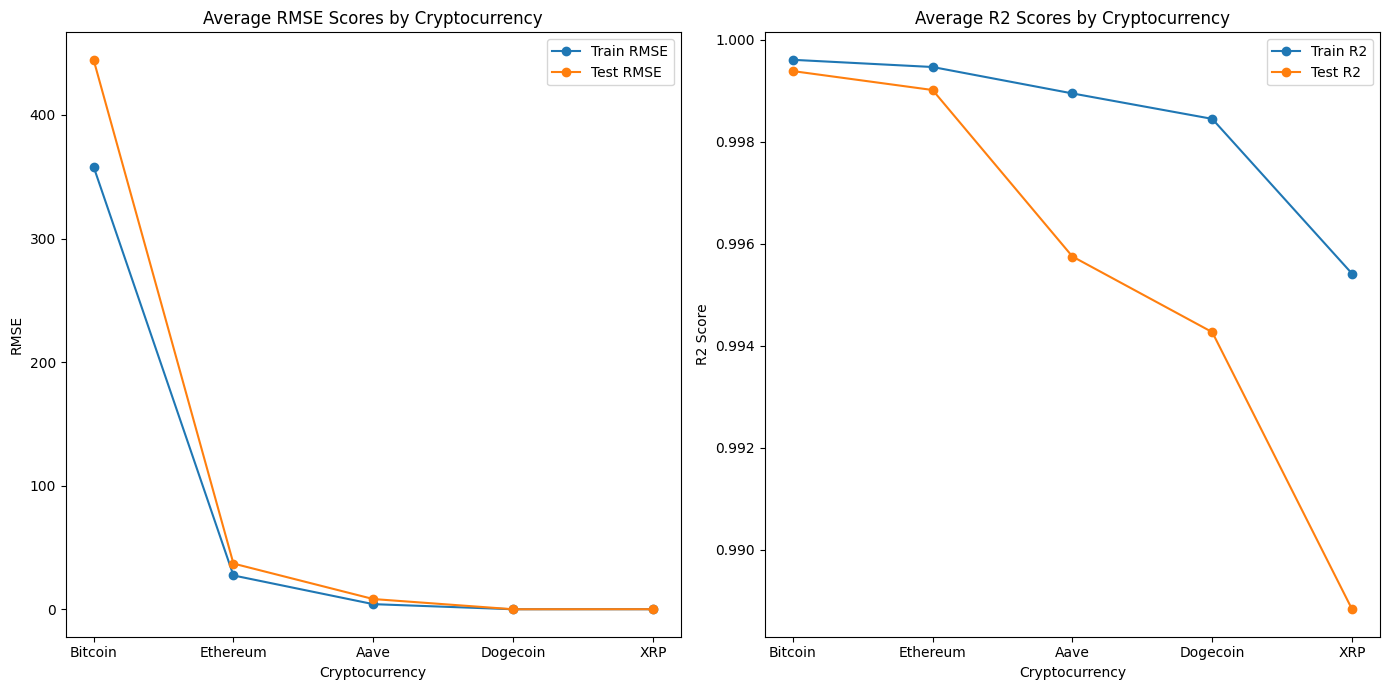

In [5]:
df_results = pd.DataFrame(results, index=['avg_rmse_train', 'avg_rmse_test', 'avg_r2_train', 'avg_r2_test']).T


# Plotting the results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(df_results.index, df_results['avg_rmse_train'], label='Train RMSE', marker='o')
plt.plot(df_results.index, df_results['avg_rmse_test'], label='Test RMSE', marker='o')
plt.title('Average RMSE Scores by Cryptocurrency')
plt.ylabel('RMSE')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_results.index, df_results['avg_r2_train'], label='Train R2', marker='o')
plt.plot(df_results.index, df_results['avg_r2_test'], label='Test R2', marker='o')
plt.title('Average R2 Scores by Cryptocurrency')
plt.ylabel('R2 Score')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.tight_layout()
plt.show()

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END c

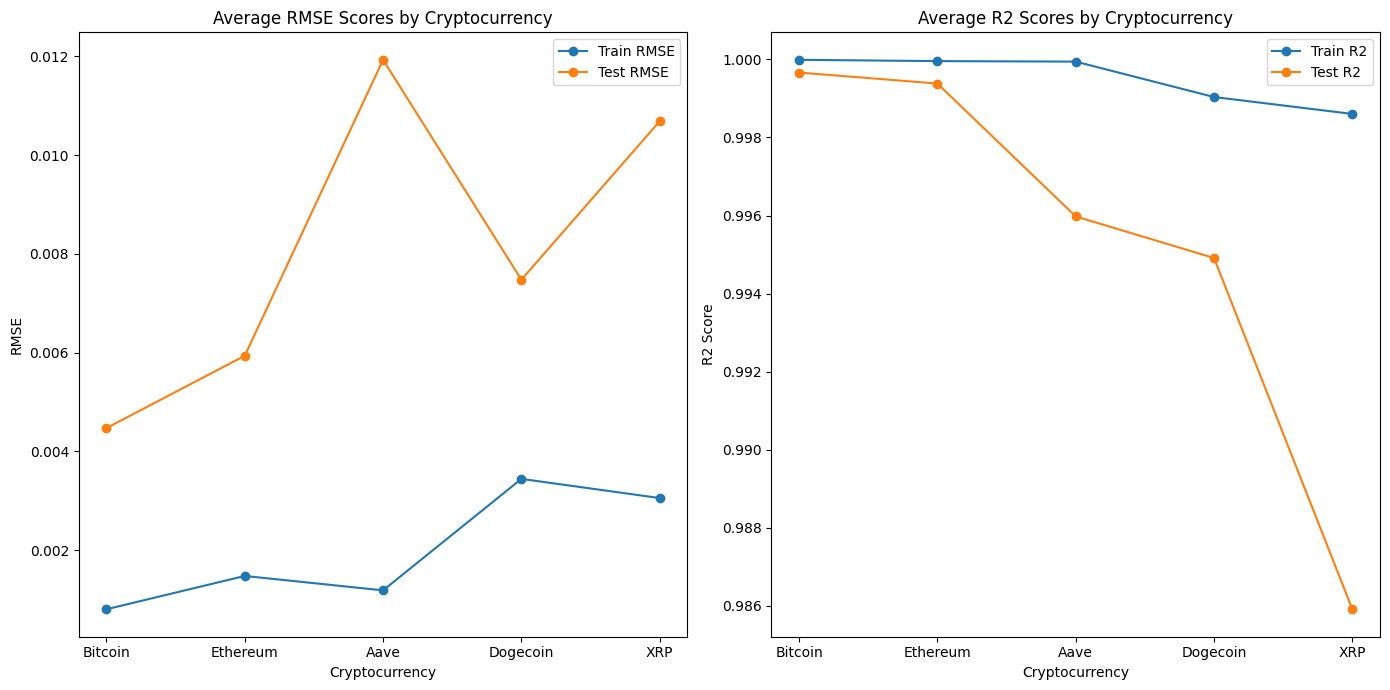

In [6]:
def perform_k_fold_cv(dataframe, n_splits=5, random_state=42, use_xgb=True):
    X = dataframe.drop('High', axis=1)
    y = dataframe['High']

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_scores_train = []
    rmse_scores_test = []
    r2_scores_train = []
    r2_scores_test = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        param_grid = {
            'n_estimators': [800, 1200],
            'max_depth': [5, 10],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.5, 0.7]
        }
        model = xgb.XGBRegressor(random_state=random_state)

        xgb_random = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=30,
                                        cv=3, verbose=2, random_state=random_state, n_jobs=-1)

        xgb_random.fit(X_train, y_train)

        best_random = xgb_random.best_estimator_

        y_train_pred = best_random.predict(X_train)
        y_test_pred = best_random.predict(X_test)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        rmse_scores_train.append(rmse_train)
        rmse_scores_test.append(rmse_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)

    avg_rmse_train = np.mean(rmse_scores_train)
    avg_rmse_test = np.mean(rmse_scores_test)
    avg_r2_train = np.mean(r2_scores_train)
    avg_r2_test = np.mean(r2_scores_test)

    return avg_rmse_train, avg_rmse_test, avg_r2_train, avg_r2_test

# Example usage
results = {}
for crypto, dataset in scaled_coins.items():
    results[crypto] = perform_k_fold_cv(dataset, use_xgb=True)

# Display results
df_results = pd.DataFrame(results, index=['avg_rmse_train', 'avg_rmse_test', 'avg_r2_train', 'avg_r2_test']).T
print(df_results)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(df_results.index, df_results['avg_rmse_train'], label='Train RMSE', marker='o')
plt.plot(df_results.index, df_results['avg_rmse_test'], label='Test RMSE', marker='o')
plt.title('Average RMSE Scores by Cryptocurrency')
plt.ylabel('RMSE')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_results.index, df_results['avg_r2_train'], label='Train R2', marker='o')
plt.plot(df_results.index, df_results['avg_r2_test'], label='Test R2', marker='o')
plt.title('Average R2 Scores by Cryptocurrency')
plt.ylabel('R2 Score')
plt.xlabel('Cryptocurrency')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
print("Average RMSE and R^2 Scores:")
for crypto in df_results.index:
    print(f"{crypto}:")
    print(df_results.loc[crypto])

Average RMSE and R^2 Scores:
Bitcoin:
avg_rmse_train    0.000806
avg_rmse_test     0.004474
avg_r2_train      0.999989
avg_r2_test       0.999663
Name: Bitcoin, dtype: float64
Ethereum:
avg_rmse_train    0.001480
avg_rmse_test     0.005937
avg_r2_train      0.999955
avg_r2_test       0.999381
Name: Ethereum, dtype: float64
Aave:
avg_rmse_train    0.001188
avg_rmse_test     0.011928
avg_r2_train      0.999943
avg_r2_test       0.995977
Name: Aave, dtype: float64
Dogecoin:
avg_rmse_train    0.003445
avg_rmse_test     0.007477
avg_r2_train      0.999036
avg_r2_test       0.994912
Name: Dogecoin, dtype: float64
XRP:
avg_rmse_train    0.003057
avg_rmse_test     0.010685
avg_r2_train      0.998602
avg_r2_test       0.985915
Name: XRP, dtype: float64


Running K-Fold CV for Bitcoin (XGBoost)
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subs

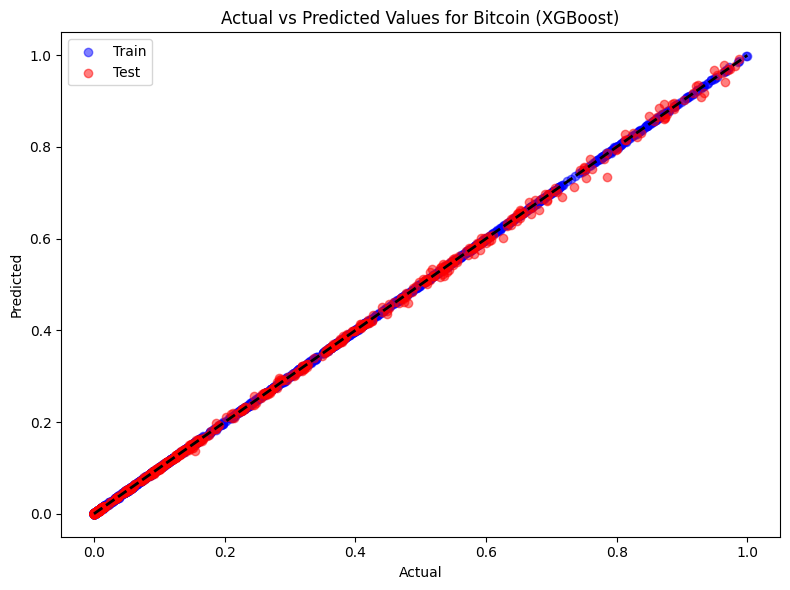

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END c

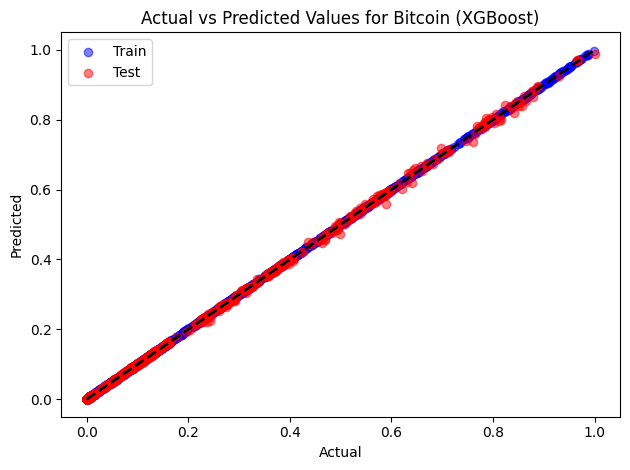

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=800, subsample=1.0; total time=   0.3s
[CV] END 

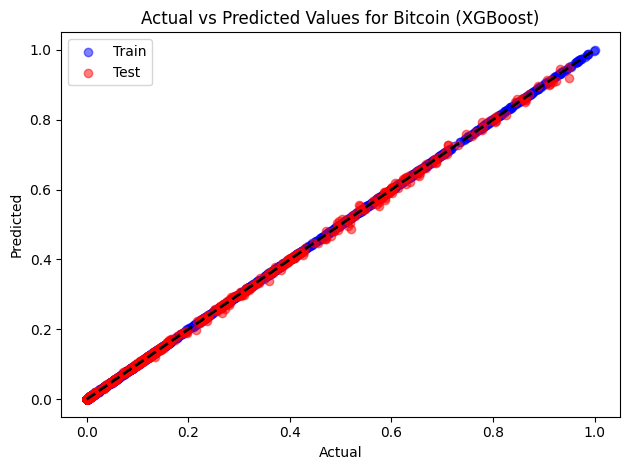

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END c

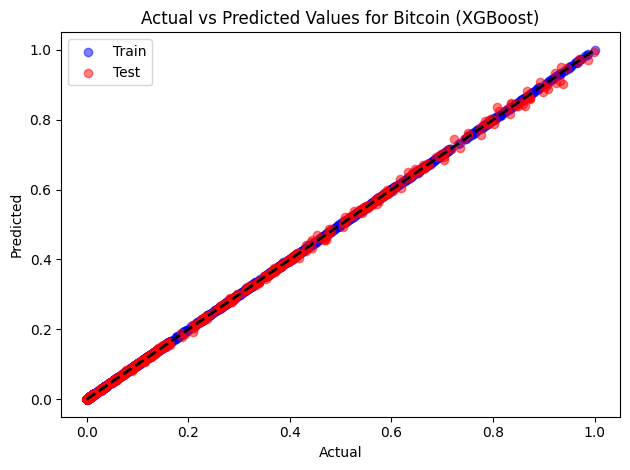

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END c

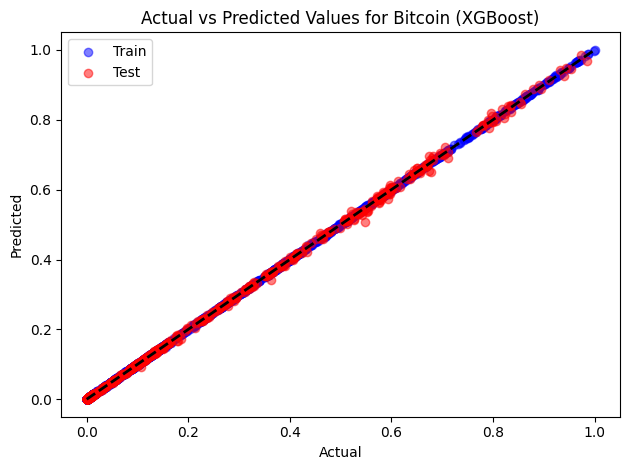

Running K-Fold CV for Ethereum (XGBoost)
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, sub

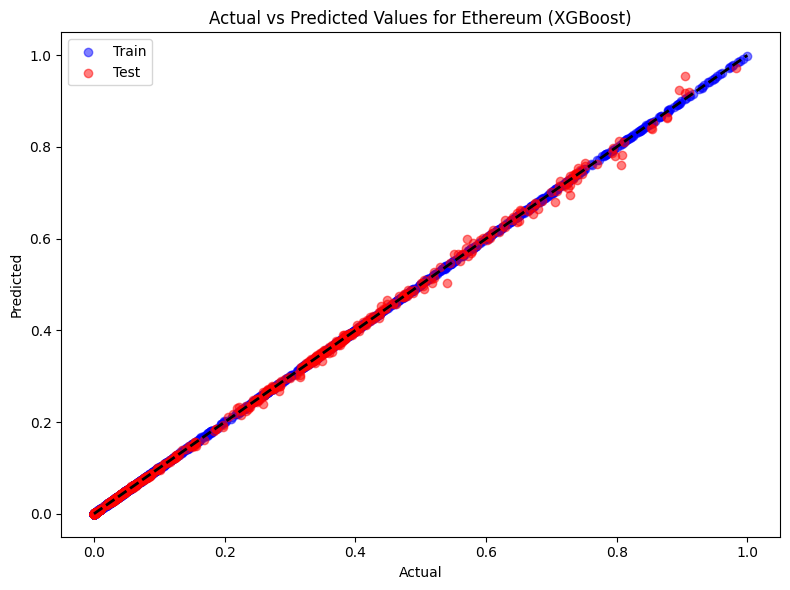

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END c

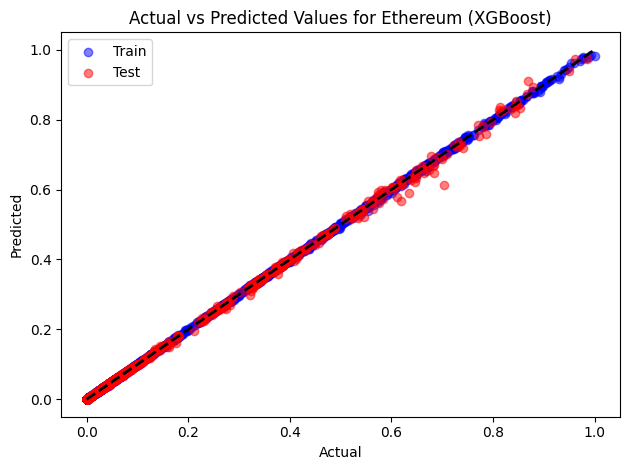

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END c

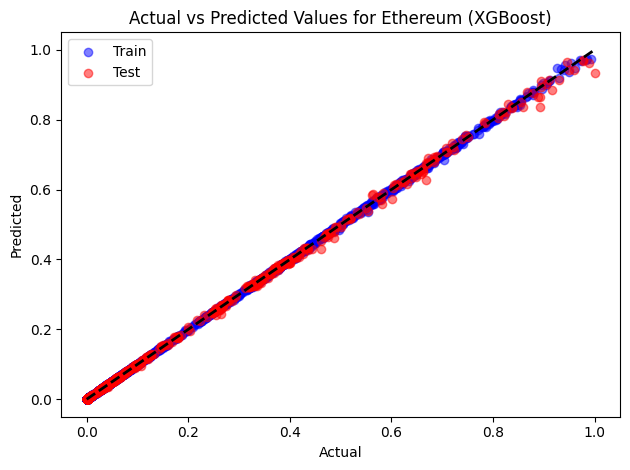

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END c

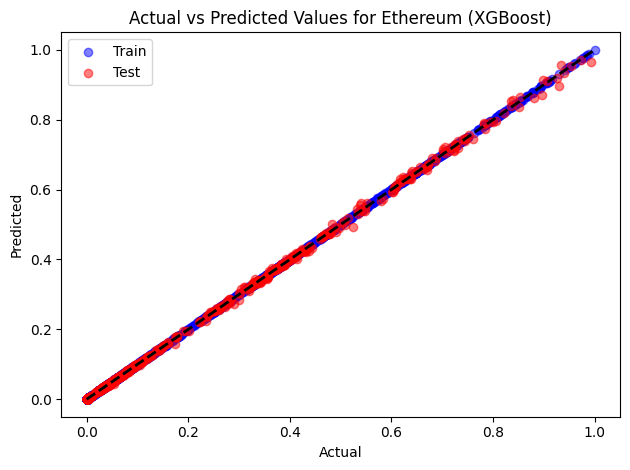

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END c

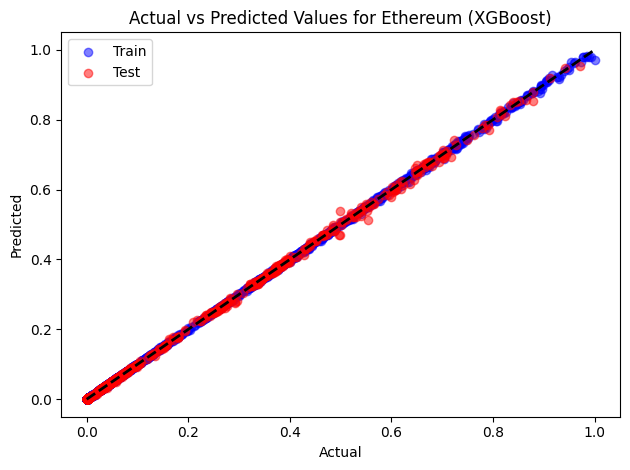

Running K-Fold CV for Aave (XGBoost)
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsamp

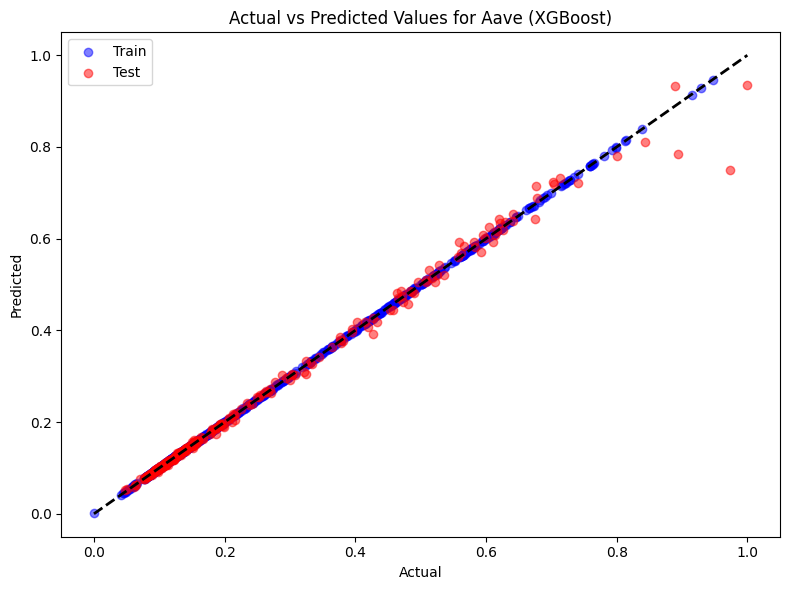

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END c

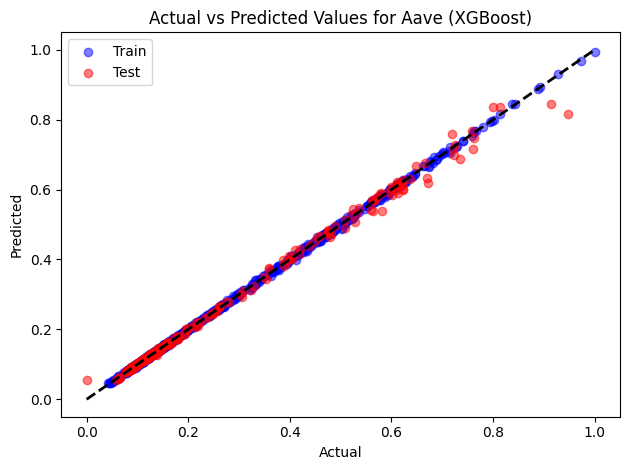

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END c

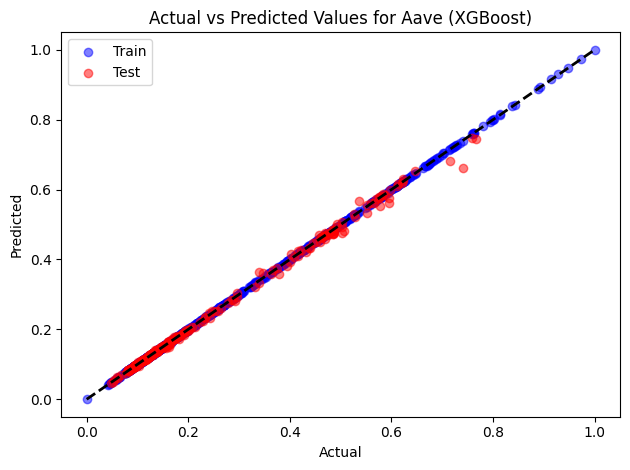

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END c

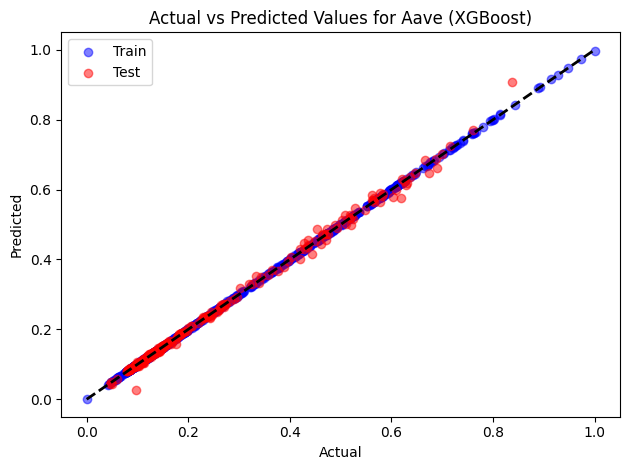

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END c

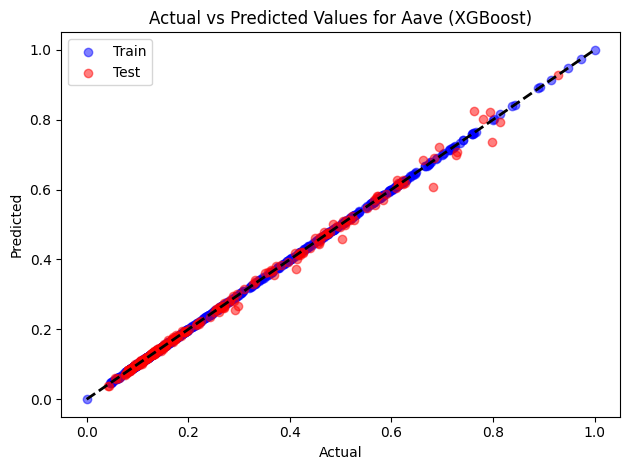

Running K-Fold CV for Dogecoin (XGBoost)
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=800, sub

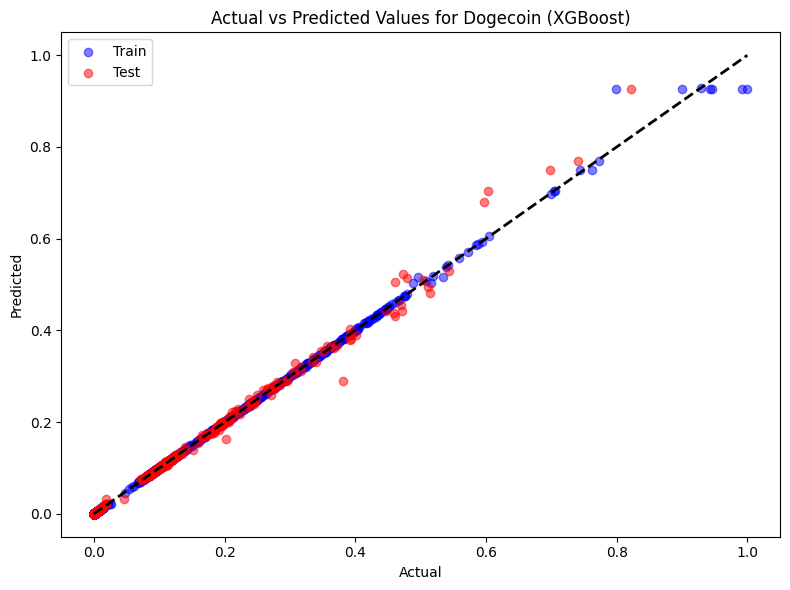

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END c

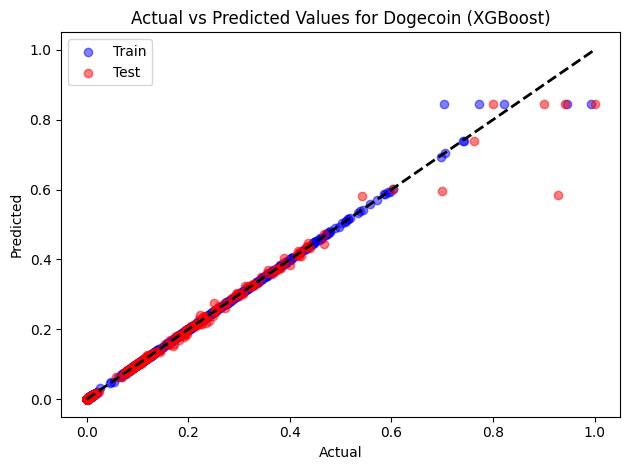

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END c

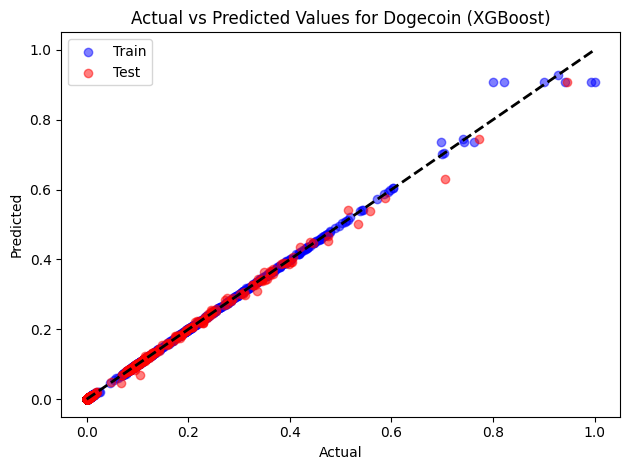

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END c

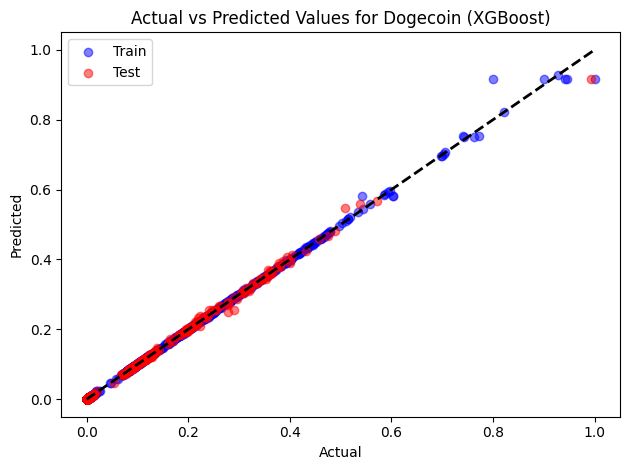

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END c

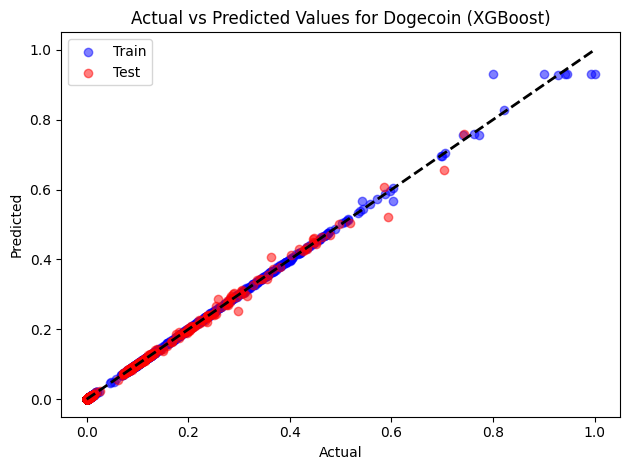

Running K-Fold CV for XRP (XGBoost)
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsampl

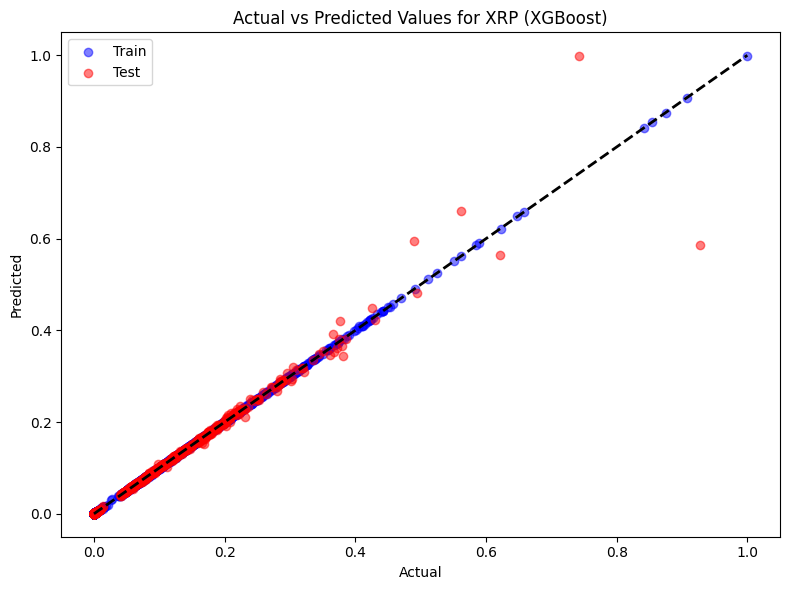

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END c

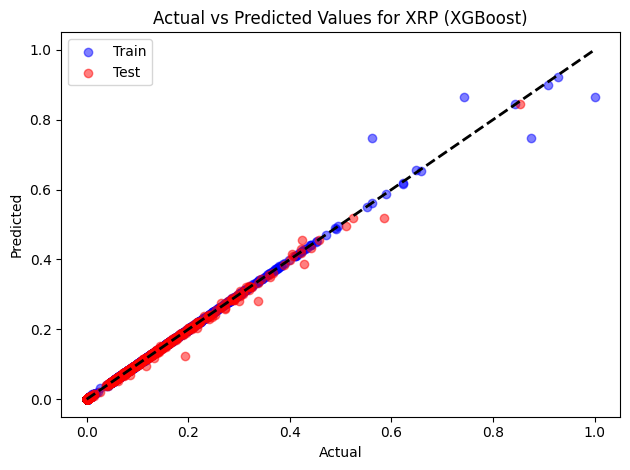

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END c

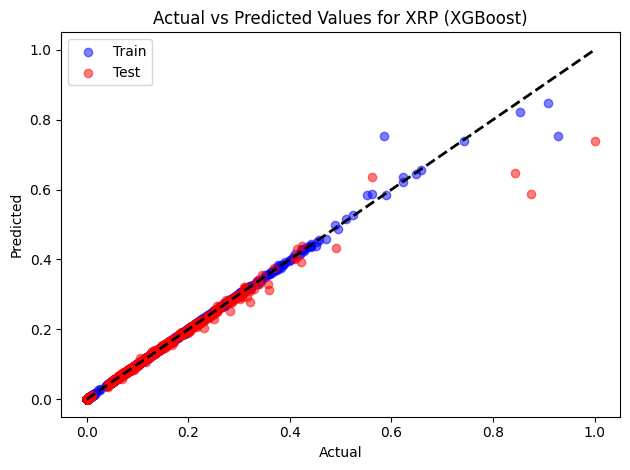

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END c

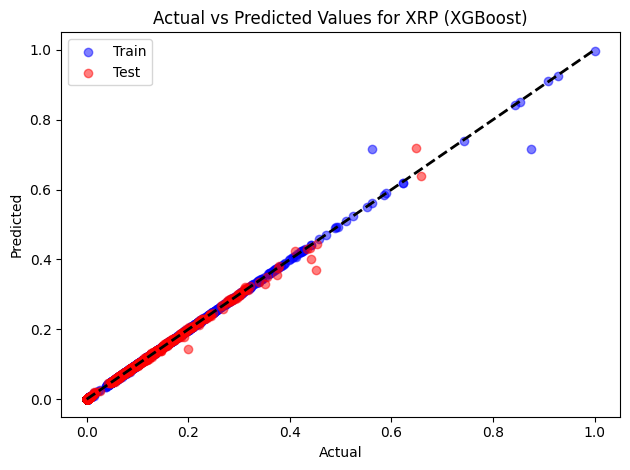

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=800, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=800, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=10, n_estimators=1200, subsample=1.0; total time=   0.3s
[CV] END c

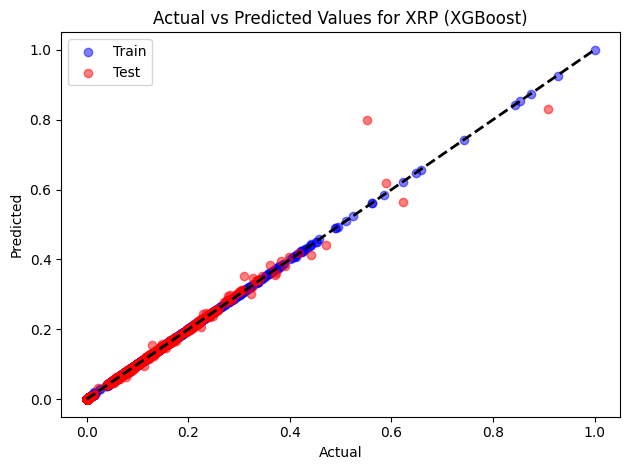

In [10]:
def perform_k_fold_cv(dataframe, crypto, n_splits=5, random_state=42, use_xgb=True):
    X = dataframe.drop('High', axis=1)
    y = dataframe['High']

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    rmse_scores_train = []
    rmse_scores_test = []
    r2_scores_train = []
    r2_scores_test = []

    plt.figure(figsize=(8, 6))
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        param_grid = {
            'n_estimators': [800, 1200],
            'max_depth': [5, 10],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.5, 0.7]
        }
        model = xgb.XGBRegressor(random_state=random_state)

        xgb_random = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=30,
                                        cv=3, verbose=2, random_state=random_state, n_jobs=-1)

        xgb_random.fit(X_train, y_train)

        best_random = xgb_random.best_estimator_

        y_train_pred = best_random.predict(X_train)
        y_test_pred = best_random.predict(X_test)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
        rmse_scores_train.append(rmse_train)
        rmse_scores_test.append(rmse_test)

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)

        # Plot the actual vs predicted values for train and test sets in the same plot
        plt.scatter(y_train, y_train_pred, color='blue', label='Train', alpha=0.5)
        plt.scatter(y_test, y_test_pred, color='red', label='Test', alpha=0.5)

    # Plot the diagonal line
        plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Actual vs Predicted Values for {crypto} (XGBoost)')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_rmse_train = np.mean(rmse_scores_train)
    avg_rmse_test = np.mean(rmse_scores_test)
    avg_r2_train = np.mean(r2_scores_train)
    avg_r2_test = np.mean(r2_scores_test)

    return avg_rmse_train, avg_rmse_test, avg_r2_train, avg_r2_test

results = {}
for crypto, dataset in scaled_coins.items():
    print(f"Running K-Fold CV for {crypto} (XGBoost)")
    results[crypto] = perform_k_fold_cv(dataset, crypto, use_xgb=True)